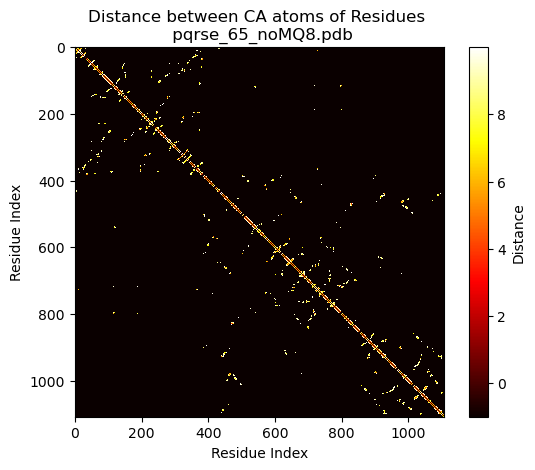

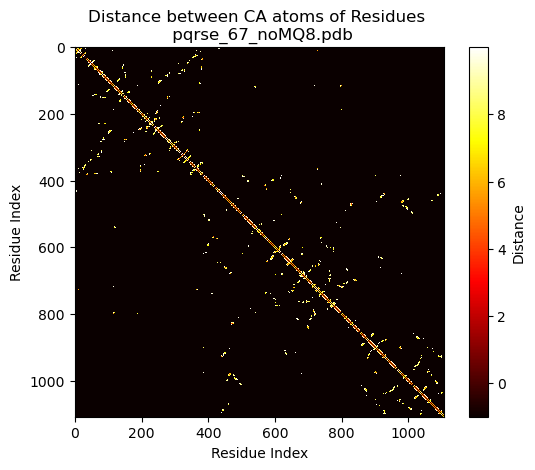

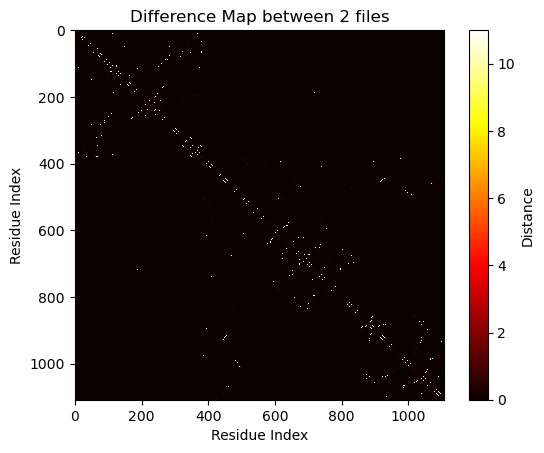

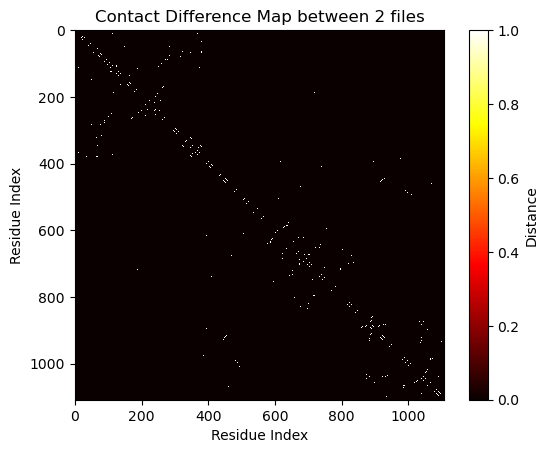

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from Bio.PDB import PDBParser

# Provide the path to your PDB file, Ensure to remove HETATMS before running
pdb_file1 = 'pqrse_65_noMQ8.pdb'
pdb_file2 = 'pqrse_67_noMQ8.pdb'

# Define the distance cutoff
distance_cutoff = 10.0  # Modify this value as needed

def calculate_distance(atom1, atom2):
    """
    Calculate the Euclidean distance between two atoms.
    """
    return np.linalg.norm(atom1.coord - atom2.coord)

def create_distance_matrix(pdb_file, distance_cutoff=10.0):
    """
    Create a distance matrix for all residues in the provided PDB file
    with distances below the given cutoff.
    """
    # Parse the PDB file
    parser = PDBParser()
    structure = parser.get_structure('pdb', pdb_file)
    
    # Get number of residues
    num_residues = len(list(structure.get_residues()))
    

    # Initialize distance matrix
    distance_matrix = np.zeros((num_residues, num_residues))
    contact_matrix = np.zeros((num_residues, num_residues))

    # Iterate over all residues
    for i, residue1 in enumerate(structure.get_residues()):
        for j, residue2 in enumerate(structure.get_residues()):
            # Calculate distance between CA atoms of residues
            try:
                atom1 = residue1['CA']
                atom2 = residue2['CA']
                dist = calculate_distance(atom1, atom2)
                if dist <= distance_cutoff:
                    distance_matrix[i, j] = dist
                    contact_matrix[i, j] = 1
                else:
                    distance_matrix[i, j] = -1
                    contact_matrix[i, j] = 0
            except KeyError:
                # If CA atom is missing, set distance to distance_cutoff
                distance_matrix[i, j] = distance_cutoff 
                contact_matrix[i, j] = 0

    return distance_matrix, contact_matrix

def plot_heatmap(distance_matrix, pdb_file):
    pdb_file = pdb_file
    fig, ax = plt.subplots()
    im = ax.imshow(distance_matrix, cmap='viridis')
    plt.imshow(distance_matrix, cmap='hot', origin='upper', interpolation='nearest')
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Distance')
    plt.title(f'Distance between CA atoms of Residues \n {pdb_file}')
    plt.show()
    
def plot_diffmap(diff_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(diff_matrix, cmap='viridis')
    plt.imshow(diff_matrix, cmap='hot', origin='upper', interpolation='nearest')
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Distance')
    plt.title(f'Difference Map between 2 files')
    plt.show()
    
def plot_contact_diffmap(diff_matrix):
    fig, ax = plt.subplots()
    im = ax.imshow(diff_matrix, cmap='viridis')
    plt.imshow(diff_matrix, cmap='hot', origin='upper', interpolation='nearest')
    plt.xlabel('Residue Index')
    plt.ylabel('Residue Index')
    plt.colorbar(label='Distance')
    plt.title(f'Contact Difference Map between 2 files')
    plt.show()
    
def absMatrix(matrix):
    return [[abs(x) for x in row] for row in matrix]

# Create distance matrix with distance cutoff
distance_matrix1, contact_matrix1 = create_distance_matrix(pdb_file1, distance_cutoff)
distance_matrix2, contact_matrix2 = create_distance_matrix(pdb_file2, distance_cutoff)
distance_matrix_diff = absMatrix(distance_matrix2 - distance_matrix1)
contact_matrix_diff = absMatrix(contact_matrix2 - contact_matrix1)

# Convert float32 to regular float for JSON serialization
distance_matrix1 = distance_matrix1.astype(float)
distance_matrix2 = distance_matrix2.astype(float)

# Plot heatmap
plot_heatmap(distance_matrix1, pdb_file1)
plot_heatmap(distance_matrix2, pdb_file2)
plot_diffmap(distance_matrix_diff)
plot_contact_diffmap(contact_matrix_diff)

In [27]:
from Bio.PDB import *
import os
import json
import numpy as np
from collections import defaultdict

def get_alpha_carbons(structure):
    alpha_carbons = []
    for model in structure:
        for chain in model:
            chain_id = chain.id
            for residue in chain:
                if is_aa(residue):
                    try:
                        alpha_carbon = residue['CA']
                        alpha_carbons.append((residue.id[1], residue.get_resname(), chain_id, alpha_carbon.get_vector()))
                    except:
                        continue
    return alpha_carbons

def calculate_distances(alpha_carbons, cutoff_distance):
    distances = defaultdict(list)
    for i, (res_id_i, res_name_i, chain_id_i, alpha_carbon_i) in enumerate(alpha_carbons):
        for j, (res_id_j, res_name_j, chain_id_j, alpha_carbon_j) in enumerate(alpha_carbons):
            if i != j:  # Exclude self-pairing
                distance = np.linalg.norm(alpha_carbon_i - alpha_carbon_j)
                if distance <= cutoff_distance:
                    distances[(res_id_i, res_name_i, chain_id_i)].append({'resID': res_id_j, 'res_name': res_name_j, 'chainID': chain_id_j, 'distance': '{:.2f}'.format(distance)})
    return distances

def main(pdb_file, cutoff_distance):
    parser = PDBParser()
    structure = parser.get_structure('pdb', pdb_file)
    alpha_carbons = get_alpha_carbons(structure)
    distances = calculate_distances(alpha_carbons, cutoff_distance)
    
    output = {'type': 'contactList', 'data': []}
    for (res_id, res_name, chain_id), partners in distances.items():
        output['data'].append({'root': {'resID': res_id, 'res_name': res_name, 'chainID': chain_id}, 'partners': partners})
    
    print(json.dumps(output, indent=2))
    filehead = os.path.splitext(pdb_file)[0]
    save_file = open(f"DistanceList_{filehead}.json", "w")  
    json.dump(output, save_file, indent = 2)
    save_file.close()  

if __name__ == "__main__":
    pdb_file = "pqrse_65_noMQ8.pdb"
    cutoff_distance = 5.0  # Set your cutoff distance here
    main(pdb_file, cutoff_distance)

{
  "type": "contactList",
  "data": [
    {
      "root": {
        "resID": 26,
        "res_name": "MET",
        "chainID": "H"
      },
      "partners": [
        {
          "resID": 27,
          "res_name": "THR",
          "chainID": "H",
          "distance": "3.90"
        }
      ]
    },
    {
      "root": {
        "resID": 27,
        "res_name": "THR",
        "chainID": "H"
      },
      "partners": [
        {
          "resID": 26,
          "res_name": "MET",
          "chainID": "H",
          "distance": "3.90"
        },
        {
          "resID": 28,
          "res_name": "LEU",
          "chainID": "H",
          "distance": "3.94"
        },
        {
          "resID": 46,
          "res_name": "THR",
          "chainID": "H",
          "distance": "4.65"
        }
      ]
    },
    {
      "root": {
        "resID": 28,
        "res_name": "LEU",
        "chainID": "H"
      },
      "partners": [
        {
          "resID": 27,
          "res_name": 